In [1]:
import time
import os
from datetime import date
print(time.ctime())
path = os.path.abspath('')
print(path)
today = date.today().strftime('%d.%m.%Y')

import warnings
warnings.filterwarnings('ignore')

Sun Jul  2 21:05:03 2023
/Users/khatran/Library/CloudStorage/OneDrive-TrườngĐạihọcPhenikaa/Quantum Computing/GitHub/GRAPE/GRAPE-for-qubit/experiments


In [2]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibm_lagos')

In [3]:
config = backend.configuration()
dt = config.dt
print(f"Sampling time: {dt * 1e9} ns")
acquire_alignment = config.timing_constraints['acquire_alignment']
granularity = config.timing_constraints['granularity']
pulse_alignment = config.timing_constraints['pulse_alignment']

import numpy as np

lcm = np.lcm(acquire_alignment, pulse_alignment)
print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")
print(f"Lagos granularity: {granularity} ")
defaults = backend.defaults()

Sampling time: 0.2222222222222222 ns
Least common multiple of acquire_alignment and pulse_alignment: 16
Lagos granularity: 16 


In [4]:
GHz = 1.0e9
MHz = 1.0e6
us = 1.0e-6
ns = 1.0e-9

qubit = 0

def get_closest_multiple_of(value, base_number):
    return int(value + base_number/2) - (int(value + base_number/2) % base_number)

def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, granularity)

def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

In [5]:
from qiskit import pulse
from qiskit.circuit import Parameter, QuantumCircuit, Gate

In [6]:
data_path = '../output/x01_π/00018_x01_lagos.h5'

In [7]:
import h5py

result = []
with h5py.File(data_path, 'r') as hf:
    data = hf.get('uks')
    result = data[...]

print(result.shape)

(13, 1, 1, 32)


In [8]:
data = result[12][0]

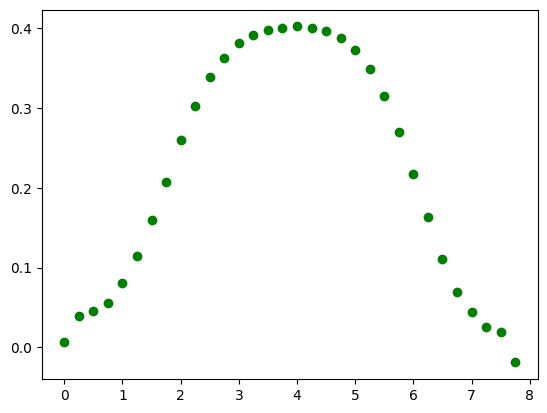

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

T = 8
N = len(data[0])
dt = T / N
ops_max_amp = [2 * np.pi * 0.073036776]
Hnames = ['x']
for jj in range(len(data)):
            plt.scatter(np.array([dt * ii for ii in range(len(data[0]))]), np.array(data[jj,:]), color='green', marker='o', label='u' + Hnames[jj] + '0')
    

In [10]:
drive_sigma_sec = config.dt * ns
drive_duration_sec = drive_sigma_sec * 1
steps = 1

with pulse.build(backend) as pi01_pulse:
    drive_duration = steps
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    for i in range(len(data[0])):
        pulse.play(pulse.library.square(duration=drive_duration,
                                        amp=data[0][i],
                                        phase=0,
                                        name='pi_pulse_' + str(i)), channel=drive_chan)

In [11]:
freq_Hz = defaults.qubit_freq_est[qubit]
freq_GHz = freq_Hz / GHz

with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq_GHz, drive_chan)
    pulse.call(pi01_pulse)

In [12]:
qc_01 = QuantumCircuit(1, 1)
qc_01.x(0)
qc_01.add_calibration('x', (0,), exc_schedule, [])

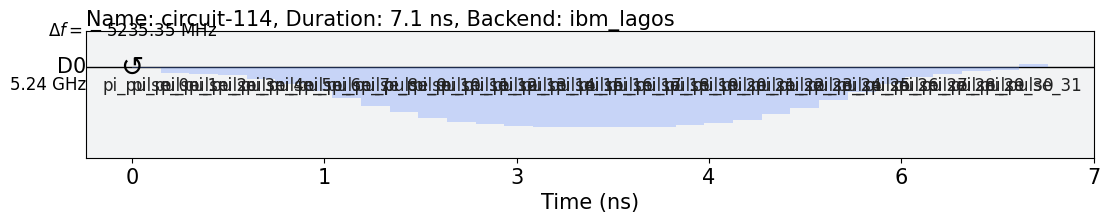

In [13]:
from qiskit import schedule

exec_schedule = schedule(qc_01, backend)
exec_schedule.draw(backend=backend)


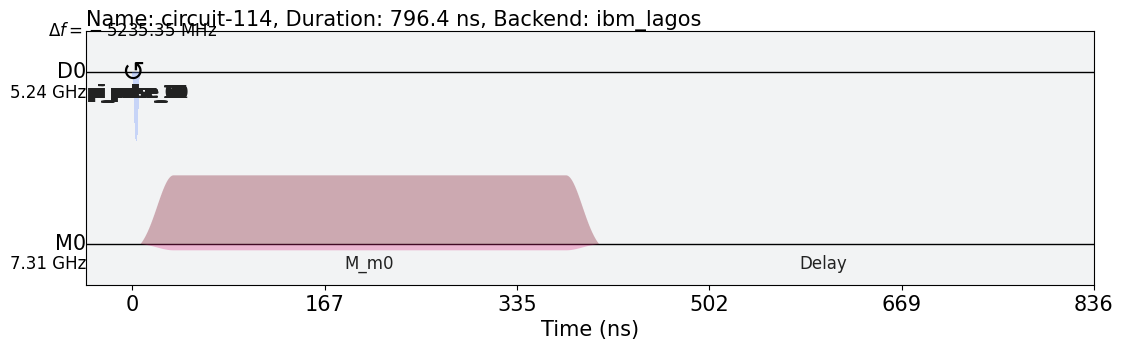

In [14]:
qc_01.measure(0,0)
exec_schedule = schedule(qc_01, backend)
exec_schedule.draw(backend=backend)

In [15]:
num_shots = 1024

job = backend.run(qc_01,
                  meas_level=1,
                  meas_return='single',
                  shots=num_shots)

In [16]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job is queued (None)